# Kenteken OCR
Dit notebook is bedoeld om de relatieve accuraatheid tussen verschillende OCR engines weer te geven. 

In [1]:
%load_ext pycodestyle_magic
%flake8_on --max_line_length 119
%load_ext autoreload
%autoreload 2

Cloud Vision installatie: https://github.com/googleapis/python-vision

In [5]:
import tensorflow as tf
from openalpr import Alpr
import numpy as np
import pickle
import io
import time
import re
from google.cloud import vision
from difflib import SequenceMatcher
from numpy import expand_dims
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import cv2
from mrcnn.model import mold_image
from PIL import Image, ImageEnhance, ImageFilter
import pytesseract
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('.../'))))
from Utility.ImageProcessing import * # noqa
import Detection # noqa
# Change path to your own tesseract installation.
# Tesseract installation: https://github.com/tesseract-ocr/tesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# Detectie Model Inladen

In [7]:
model, cfg = Detection.LoadModel('mask_rcnn_plate_cfg_0100.h5')

mask_rcnn_plate_cfg_0100.h5


# Functie Definities
De functies de gebruikt worden voor de evaluatie

In [22]:
def predict_once(img, model, cfg, debug=False):
    """
    Function for predicting/detecting a plate's location. One picture per call.
    :param img: path to the image we want to detect plates on
    :param model: license plate detection model
    :param cfg: configuration for the model
    :type img: string
    :type model: .h5 file
    :type cfg: PredictionConfig
    :return boxes: detected bounding boxes
    :return image: the img
    :rtype boxes: list
    :rtype image: image
    """
    # load image and mask
    image = cv2.imread(img)
    # convert pixel values (e.g. center)
    scaled_image = mold_image(image, cfg)
    # convert image into one sample
    sample = expand_dims(scaled_image, 0)
    # make prediction
    yhat = model.detect(sample, verbose=0)[0]

    if debug:
        # show the figure
        # plot raw pixel data
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Predicted')
        print("Confidence score:", yhat['scores'])

        # define subplot
        ax = plt.gca()
        # plot each box
        for box in yhat['rois']:
            # get coordinates
            y1, x1, y2, x2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
        plt.show()

    return yhat['rois'], image

In [9]:
def Detect_And_Read_Plates(img, model, cfg, debug=False, plate_num=None, OCR="T", lang="plate_model"):
    """
    Function for both detecting (Mask RCNN) and reading plates (OCR)
    :param img: path to an imagine containing a car and visible license plate
    :param model: the Mask RCNN model
    :param cfg: Mask RCNN configuration
    :param debug: debug mode for Mask RCNN detection
    :param plate_num: list containing 1 or more license plates
    :param OCR: the OCR engine to be tested
    :param lang: the language to be tested. only applies to Tesseract

    :type img: string
    :type model: string
    :type cfg: Config
    :type debug: bool
    :type plate_num: list of strings
    :type OCR: string
    :type lang: string
    """
    boxes, img = predict_once(img, model, cfg)

    first_c = first_crops(img, boxes)

    total_speed = [0, 0]
    total_accuracy = [0, 0]

    for crop in first_c:
        second_crop = secondCrop(crop)
        contrasted_img = increase_contrast_2(increase_contrast_1(second_crop))
        contrasted_img = apply_brightness_contrast(contrasted_img, brightness=-50, contrast=30)

        if OCR == "T":
            start_time = time.time()
            plates = Tesseract_OCR(contrasted_img, lang)
            speed = round(time.time() - start_time, 3)
            for plate in plate_num:
                plate = re.sub(r'[^\w]', '', plate)
                print("Plate: ", plate, "Found plates: ", [re.sub(r'[^\w]', '', x) for x in plates])
                max_accuracy = max([SequenceMatcher(None, plate, re.sub(r'[^\w]', '', x)).ratio() for x in plates])
                total_accuracy[0] += max_accuracy
                total_accuracy[1] += 1
                print("Max accuracy: " + str(max_accuracy))
            print("Speed: " + str(speed))
            print()
            total_speed[0] += speed
            total_speed[1] += 1
        elif OCR == "G":
            temp_img = Image.fromarray(contrasted_img)
            temp_img.save(r"./temp/temp_img.jpg")
            start_time = time.time()
            with io.open(r"./temp/temp_img.jpg", 'rb') as image_file:
                content = image_file.read()
                image = vision.Image(content=content)
                client = vision.ImageAnnotatorClient()
                response = client.text_detection(image=image)
                texts = response.text_annotations
            if len(texts) > 0:
                plates = [z.description for z in texts]
                speed = round(time.time() - start_time, 3)
                for plate in plate_num:
                    print("Plate: ", plate, "Found Plates: " + str(plates))
                    max_accuracy = max_accuracy = max([SequenceMatcher(None, plate, x).ratio() for x in plates])
                    total_accuracy[0] += max_accuracy
                    total_accuracy[1] += 1
                    print("Max accuracy: " + str(max_accuracy))
                print("Speed: " + str(speed))
                print()
                total_speed[0] += speed
                total_speed[1] += 1
        elif OCR == "O":
            temp_img = Image.fromarray(contrasted_img)
            temp_img.save(r"./temp/temp_img.jpg")
            jpeg_bytes = open(r"./temp/temp_img.jpg", "rb").read()
            start_time = time.time()
            result = alpr.recognize_array(jpeg_bytes)
            plates = result['results']
            speed = round(time.time() - start_time, 3)
            if len(plates) > 1:
                for plate in plate_num:
                    print("Plate: ", plate, "Found Plates: " + str(plates))
                    max_accuracy = max_accuracy = max([SequenceMatcher(None, plate, x).ratio() for x in plates])
                    total_accuracy[0] += max_accuracy
                    total_accuracy[1] += 1
                    print("Max accuracy: " + str(max_accuracy))
            total_speed[0] += speed
            total_speed[1] += 1
            print("Speed: "+str(speed))

    return (total_speed, total_accuracy)

# Bepaling Threshold
Eigen tests op foto's: <br>
foto 1: 5, 7, 12, 13 <br>
foto 2: 10, 13, 14 <br>
foto 3: 3, 6 <br>
foto 4: 3, 12 <br>
foto 5: 12 <br>
foto 6: 11, 17 <br>
foto 7: 1, 4, 5, 7 <br>
foto 8: 2, 14 <br>
foto 9: 4, 16 <br> 

In [10]:
pic1 = [5, 7, 12, 13]
pic2 = [10, 13, 14]
pic3 = [3, 6]
pic4 = [3, 12]
pic5 = [12]
pic6 = [11, 17]
pic7 = [1, 4, 5, 7]
pic8 = [2, 14]
pic9 = [4, 16]

all_pics = [pic1, pic2, pic3, pic4, pic5, pic6, pic7, pic8, pic9]
minimum = []
maximum = []
for pic in all_pics:
    minimum.append(min(pic))
    maximum.append(max(pic))
print("minimum="+str(np.median(minimum)), "maximum="+str(np.median(maximum)))

minimum=4.0 maximum=13.0


In [11]:
def Tesseract_OCR(img, lang):
    im_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (thresh, im_bw) = cv2.threshold(im_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    counter = 0
    plates = []
    for i in range(20, 70, 5):
        im_bw = cv2.threshold(im_gray, thresh + i, 255, cv2.THRESH_BINARY)

        plate_crop = Image.fromarray(im_bw[1])
        new_size = tuple(14*x for x in plate_crop.size)
        resized_img = plate_crop.resize(new_size, Image.ANTIALIAS)

        text = pytesseract.image_to_string(resized_img, lang=lang, config='--psm 10')
        text = re.sub('[\n-\x0c]',  '', text)
        plates.append(re.sub('[^A-Za-z0-9 ]+', '', text))
        # print("Detected license plate Number is:", text+" Iteration= "+str(counter))
        counter += 1
    plates = list(set(plates))
    return plates

# Plates
Het path is specifiek naar onze test dataset. Dit mag worden aangepast naar een eigen test data set als daar behoefte aan is. Let wel: de resultaten kunnen dan afwijken van wat er genoteerd staat in het advies rapport. 

In [12]:
path = r"../Dataset/MaskRCNNEvaluation/"
plates = [
             ["56-TK-JL"], ["PJ-034-T"], ["07-NJB-5"],
             ["17-HK-LG"], ["J-179-RT"], ["9-XHP-78"],
             ["76-XJ-XP"], ["TX-979-F"],
             ["24-XV-LZ"],
             ["TX-882-S"], ["92-RZ-XZ", "98-ST-XX"], ["29-JTF-7"],
             ["8-ZKX-27"], ["85-NB-XG"],
             ["64-PH-TH"], ["29-LJK-3"],
             ["G-499-KH"], ["KF-544-F"], ["PL-32-TG"],
             ["56-ZF-DL"], ["G-499-KH"], ["53-RGT-1"],
             ["GL-395-X"], ["80-XB-FD"], ["ST-185-K", "GL-805-X", "5-XZV-10"],
             ["J-179-RT"], ["XT-567-K"],
             ["KD-362-J"], ["NJ-621-S"], ["9-ZNK-53"],
             ["84-KLJ-9", "55-NZ-TV"], ["47-JR-LV"], ["31-PX-KR"],
             ["KN-621-V"], ["BX-41-PZ"], ["GX02 BCF"], ["H 786 POJ"]
        ]
print(len(plates))

37


In [20]:
def Engine_Evaluation(Engine='T', lang='eng'):
    """
    Function for evaluating an OCR engine.

    :param Engine: the engine to be evaluated
    :param lang: language (only applies to Tesseract)

    :type Engine: string
    :type lang: string

    :return avg_speed: the average amount of seconds required to read one plate
    :return avg_accuracy: the average accuracy for the engine per plate

    :rtype avg_speed: float
    :rtype avg_accuracy: float
    """
    speed = 0
    accuracy = 0
    speed_counter = 0
    accuracy_counter = 0

    avg_accuracy = 0
    avg_speed = 0

    for i in range(37):
        print("picture: "+str(i+1))
        pic = str(i+1).zfill(3)
        pic_path = path + pic + ".jpg"
        result = Detect_And_Read_Plates(pic_path, model, cfg, debug=False, OCR=Engine, plate_num=plates[i], lang=lang)
        speed += result[0][0]
        speed_counter += result[0][1]

        accuracy += result[1][0]
        accuracy_counter += result[1][1]
        print()

    avg_speed = speed / speed_counter
    print("Average time: " + str(avg_speed))
    if accuracy > 0:
        avg_accuracy = accuracy / accuracy_counter

        print("Average accuracy: " + str(avg_accuracy))
    return avg_speed, avg_accuracy

# Tesseract

picture: 1
Plate:  56TKJL Found plates:  ['', 'w', 'WW', 'W', 'q', 'Ww', 'A', 'ws']
Max accuracy: 0.0
Speed: 5.533

Plate:  56TKJL Found plates:  ['B6TKIL', '56THSL', '56TKSL', 'S6TKSL', 'BETKSL']
Max accuracy: 0.8333333333333334
Speed: 4.326


picture: 2
Plate:  PJ034T Found plates:  ['SaaeeeSee', 'aanan7aa', 'ameee', 'ceee', 'asmeebce', 'x', 'Saeee', 'aOL', 'x', 'aewom']
Max accuracy: 0.0
Speed: 4.391


picture: 3
Plate:  07NJB5 Found plates:  ['LOFMIES', '1O7MIRS', 'O7NIRS', 'O7NIBS', 'O7FNIRS', '1O7KIB5', '1G7MIS', 'O7NIBS']
Max accuracy: 0.5
Speed: 4.513


picture: 4
Plate:  17HKLG Found plates:  ['fireGeet', 'monfas', 'iameis', 'Wee', 'iene', 'teefF', 'Reette', 'Ta', 'TineGee', 'Tinhmeee']
Max accuracy: 0.15384615384615385
Speed: 4.639


picture: 5
Plate:  J179RT Found plates:  ['ftws', 'tf', 'ftwr', 'fwy', 'ro', 'tFs', 'F', 'if2', 'ifwo', 'ifwe']
Max accuracy: 0.0
Speed: 4.088

Plate:  J179RT Found plates:  ['oean', 'Se7et', 'BEe', 'eea', 'eeme', 'AtawFN', 'BEowth', 'Oewe', 'SFk

(5.667468085106383, 0.418107331265226)

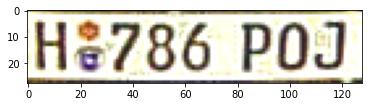

In [23]:
Engine_Evaluation(Engine='T')

# Google

picture: 1
Plate:  56-TK-JL Found Plates: ['56-TK-JL-\n', '56-TK-JL-']
Max accuracy: 0.9411764705882353
Speed: 0.539


picture: 2

picture: 3
Plate:  07-NJB-5 Found Plates: ['07-NJB-5\n', '07-NJB-5']
Max accuracy: 1.0
Speed: 0.566


picture: 4

picture: 5

picture: 6
Plate:  9-XHP-78 Found Plates: ['9-XHP-78\n', '9-XHP-78']
Max accuracy: 1.0
Speed: 0.687

Plate:  9-XHP-78 Found Plates: ['19-XHP-78\n', '19-XHP-78']
Max accuracy: 0.9411764705882353
Speed: 0.501


picture: 7

picture: 8
Plate:  TX-979-F Found Plates: ['TX-979-F\n', 'TX-979-F']
Max accuracy: 1.0
Speed: 0.704


picture: 9
Plate:  24-XV-LZ Found Plates: ['24-XV-LZ\n', '24-XV-LZ']
Max accuracy: 1.0
Speed: 0.558


picture: 10
Plate:  TX-882-S Found Plates: ['T-682-5\n', 'T-682-5']
Max accuracy: 0.6666666666666666
Speed: 0.844


picture: 11

picture: 12
Plate:  29-JTF-7 Found Plates: ['2917P\n', '2917P']
Max accuracy: 0.46153846153846156
Speed: 0.685


picture: 13
Plate:  8-ZKX-27 Found Plates: ['17-07-8\n', '17-07-8']
Max accu

(0.6693999999999999, 0.7224084089918373)

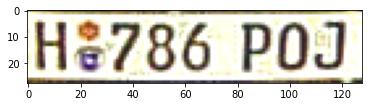

In [24]:
Engine_Evaluation(Engine='G')

# Open ALPR

hello
picture: 1
Speed: 1.977
Speed: 0.001

picture: 2
Speed: 0.0

picture: 3
Speed: 0.002

picture: 4
Speed: 0.003

picture: 5
Speed: 0.002
Speed: 0.001

picture: 6
Speed: 0.003
Speed: 0.008

picture: 7
Speed: 0.003

picture: 8
Speed: 0.003
Speed: 0.005
Speed: 0.003

picture: 9
Speed: 0.002
Speed: 0.003

picture: 10
Speed: 0.002

picture: 11
Speed: 0.003

picture: 12
Speed: 0.001
Speed: 0.003

picture: 13
Speed: 0.002

picture: 14

picture: 15

picture: 16
Speed: 0.003
Speed: 0.004

picture: 17
Speed: 0.003

picture: 18
Speed: 0.003

picture: 19

picture: 20
Speed: 0.002

picture: 21
Speed: 0.002

picture: 22
Speed: 0.001

picture: 23
Speed: 0.002

picture: 24
Speed: 0.0

picture: 25
Speed: 0.001
Speed: 0.0
Speed: 0.001

picture: 26
Speed: 0.001

picture: 27
Speed: 0.021

picture: 28
Speed: 0.003

picture: 29

picture: 30

picture: 31
Speed: 0.001
Speed: 0.003
Speed: 0.001

picture: 32
Speed: 0.002
Speed: 0.001
Speed: 0.001
Speed: 0.002

picture: 33
Speed: 0.002

picture: 34
Speed: 0.

(0.04631914893617017, 0)

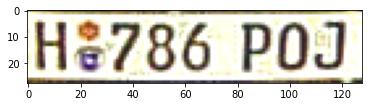

1:120: E501 line too long (239 > 119 characters)


In [25]:
alpr = Alpr("eu", r"C:/Users/midni/AppData/Local/Programs/Python/Python37/Lib/site-packages/openalpr/openalpr_64/openalpr.conf", r"C:/Users/midni/AppData/Local/Programs/Python/Python37/Lib/site-packages/openalpr/openalpr_64/runtime_data/")
alpr.set_detect_region(False)
Engine_Evaluation(Engine='O')

# Tesseract Custom Models
Er was uiteindelijk geen voorkeur voor Cloud Services waardoor Google als OCR engine afvalt. Hierdoor blijft Tesseract over als hoogst scorende. Echter scoort Tesseract een flink stuk lager dan Google. Daarom is er gekeken of het finetunen van Tesseract nut heeft. Hier onder zijn de resultaten van 7 gefinetunde modellen te zien. 

picture: 1
Plate:  56TKJL Found plates:  ['S', 'ZS', 'ZF', '5U', 'ZU', '9S', 'ZL', 'SU']
Max accuracy: 0.25
Speed: 6.556

Plate:  56TKJL Found plates:  ['88SXOS', '886382SZ', 'DZ', '88S', '864847', '86SSAG', 'ZZ', '865847', '863S2SZ', '864047']
Max accuracy: 0.16666666666666666
Speed: 4.602


picture: 2
Plate:  PJ034T Found plates:  ['GGVBQQTTTBEZCVCZY', 'DDTTTTTZAW2U6ZZ6AU', 'ZGAG', 'ZYZZ', 'D0RETFZCXXACG', 'XSZYTQQTTQZSCYVVCVC', 'TTXYTZG', 'XGXTTQQTTTQZY2WYVC', 'DTTCC', 'ZTTTTCTCZV']
Max accuracy: 0.21052631578947367
Speed: 5.606


picture: 3
Plate:  07NJB5 Found plates:  ['LBCES', 'L865XGWO878', 'BZEZZZ', 'LB65GO878', 'L86GO878', 'L0EA8Z2', 'BZOMECS', 'ZZ', 'EZ']
Max accuracy: 0.18181818181818182
Speed: 4.842


picture: 4
Plate:  17HKLG Found plates:  ['BAC', 'QZ', 'LZ', 'BGAAZ', 'BZ', 'QZZ', 'LAS', 'BAGC', 'IZ', 'ACVC9AVA']
Max accuracy: 0.25
Speed: 5.071


picture: 5
Plate:  J179RT Found plates:  ['CBZ', 'DM', 'ZZ', '1', 'EZ']
Max accuracy: 0.2857142857142857
Speed: 5.098

Plate: 

Plate:  KN621V Found plates:  ['BBSSZ08', 'EK', 'BBG8BRE', 'BBX8BR8E', 'BCS8PZ', 'ZZ', 'AE', 'ABRE', 'JBBS8PZ']
Max accuracy: 0.25
Speed: 4.434


picture: 35
Plate:  BX41PZ Found plates:  ['B8SII88', 'B8SIL88', 'B84IIBE', 'B8SIL8E', 'B88SJI8E', 'B84IBE', 'B84IIBE']
Max accuracy: 0.3333333333333333
Speed: 17.392


picture: 36
Plate:  GX02BCF Found plates:  ['1BR0BEBDP', '1BR08BBDP', 'BB8B8BBE', '1BR0B80E', '1BR0880E', '1BR0EB0E', '1BR0BEBDE', '1BR0BE80E']
Max accuracy: 0.26666666666666666
Speed: 4.876


picture: 37
Plate:  H786POJ Found plates:  ['F5Z861EB4', 'R6Z8B1R08', 'R608B1R0B0', 'R80Z881RB0B', 'F6Z881RB08', 'F58Z881R0B6', 'F58Z861R0B4', 'R56E881RBB0', '08Z801EB4', 'F5Z86TR0B4']
Max accuracy: 0.25
Speed: 5.166


Average time: 6.982468085106384
Average accuracy: 0.24509638244362045


(6.982468085106384, 0.24509638244362045)

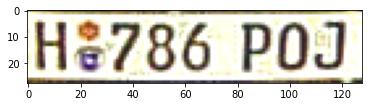

In [45]:
Engine_Evaluation(Engine='T', lang='plate_model')

picture: 1
Plate:  56TKJL Found plates:  ['FJ', 'J', '71', 'JJ']
Max accuracy: 0.2857142857142857
Speed: 6.255

Plate:  56TKJL Found plates:  ['SZF673E', 'L117', '6716', '656TZU3E', '3FTRZE', '67S7Y3Z', '67T7Y3Z', '6ZL63E', '33FRC', '6C7T6UE']
Max accuracy: 0.42857142857142855
Speed: 4.654


picture: 2
Plate:  PJ034T Found plates:  ['EBTTZTZEEZTSZZYVVZZZWZZZC', 'EEEEZFEEEBZEEEES6EEEEZZZZZZSZEZ', 'EZTTZEZZ112ZZEEZZVZEEEZVZ6ZZEZZZZZZ', 'EEDZZEZ71SEEEVZEEEEZZEEEZZZZECGZZ', 'EEEEFFEEEE7REEEEEZEEEZZZZZZZEZZZZZ', 'EEEZYFZEZTTZEEZZEZZZZZZZDCCC', 'ZZYTZ2ZZZEEEZTSZZYVZZZCWZQCZCZ', 'EEZFFSEEEZS6EFEEEEEZCZZZZZZZZ', 'EEZ7TZZTZEEZESZZYZZZZCMCQCZCZ', 'EE7FEETZEZZZEZZZ7ZZZZZZZZ']
Max accuracy: 0.06451612903225806
Speed: 4.648


picture: 3
Plate:  07NJB5 Found plates:  ['LZ737', 'LL7ZIFZ7', 'LL37717', 'LL7S7', 'LD77F7', 'LLY37T7', 'LLY7FF7', 'FDU1ELT', 'LUV777', 'LL777']
Max accuracy: 0.18181818181818182
Speed: 4.685


picture: 4
Plate:  17HKLG Found plates:  ['Z77TEZC', 'ZT7TFTZZ', 'ZZYZZ', 'EZEZ7ZZ'

Plate:  84KLJ9 Found plates:  ['7TT77ZL', 'TUTTZ7Z', 'UJ7TZZZ', 'UTZ', '1TZLZ3', '37TEZZ', 'TTZZUZ', 'TZU']
Max accuracy: 0.16666666666666666
Plate:  55NZTV Found plates:  ['7TT77ZL', 'TUTTZ7Z', 'UJ7TZZZ', 'UTZ', '1TZLZ3', '37TEZZ', 'TTZZUZ', 'TZU']
Max accuracy: 0.2222222222222222
Speed: 6.27

Plate:  84KLJ9 Found plates:  ['FEZZ7TFZ77TF7T7I', 'FETE777776111', 'ZTE', 'FEZE7775', 'BEZEE7T7Z776177I', 'ZZ747', 'ZFEAZ7F7F7F1FFFFF1EFF1F', 'ZT77', 'FA7DT77E77T77I']
Max accuracy: 0.18181818181818182
Plate:  55NZTV Found plates:  ['FEZZ7TFZ77TF7T7I', 'FETE777776111', 'ZTE', 'FEZE7775', 'BEZEE7T7Z776177I', 'ZZ747', 'ZFEAZ7F7F7F1FFFFF1EFF1F', 'ZT77', 'FA7DT77E77T77I']
Max accuracy: 0.4444444444444444
Speed: 4.304


picture: 32
Plate:  47JRLV Found plates:  ['7ZTZT', 'Z37Z3T7ET', 'L7Z27E1', 'L7Z237ET', 'ZTE', '7ZTTE1', '13X5LV', 'Z72T7E', 'T7TJ7E7', 'L3X1ULV']
Max accuracy: 0.3333333333333333
Speed: 4.199

Plate:  47JRLV Found plates:  ['777DIPLI', '777EJPLI', 'ULF', '72EJFLI', 'ZUUBFL1', '777EP

(5.661553191489362, 0.26114441271487115)

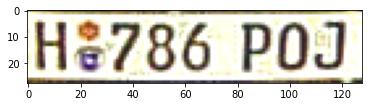

In [46]:
Engine_Evaluation(Engine='T', lang='plate_model_1')

picture: 1
Plate:  56TKJL Found plates:  ['ZX', 'XK', '71', '91', 'Z1']
Max accuracy: 0.25
Speed: 5.594

Plate:  56TKJL Found plates:  ['7PFGE', '3LZF', 'SSTBF', 'SSTS2', 'S37TS3', 'SSTE', 'SSTSE', 'SSTS7B', 'STS3', '7LTE']
Max accuracy: 0.2
Speed: 4.435


picture: 2
Plate:  PJ034T Found plates:  ['SCZSSSCO', 'QSCTSTZZTTTZCCZCCC', 'XSCTSTTTSZSGZYCGCCGCC', 'XGTTSTTTSSZZSCTTZCCGC', 'SXTTTSSS1TTTSWSC22AZZC', 'KXQTYTTSZTTTCCGC', 'SCTSTCSSCSCC', 'SXTTCSSGGG', 'STSSTTTCTGC', 'TTSSTZTCGCTOZCZ']
Max accuracy: 0.125
Speed: 4.627


picture: 3
Plate:  07NJB5 Found plates:  ['LZTST', 'LZTS', 'LEZZS', 'SZTS', 'UETS', 'ZZZS', 'LZTZST']
Max accuracy: 0.0
Speed: 4.693


picture: 4
Plate:  17HKLG Found plates:  ['ESFZ', 'LZ', 'LZTSS', 'JSZ', 'IZ7ZZ', 'LSZS', '3SZ', 'LTZS', 'SS', 'LZZZ']
Max accuracy: 0.25
Speed: 4.758


picture: 5
Plate:  J179RT Found plates:  ['SZSS', '7SSSX', 'ZZSZ', '7SSX', 'TZSS', 'ESSS', 'GZSG', 'SZSSZS', 'ZSSS', 'TSSS']
Max accuracy: 0.2
Speed: 4.23

Plate:  J179RT Found plates: 

Plate:  H786POJ Found plates:  ['H5788DU', 'GZSZS', 'U5786DU', 'LSHS72', 'D57DSH2', 'TL788HU', '5788THU', 'L578TDG', 'LTYSDH', '3786GU']
Max accuracy: 0.46153846153846156
Speed: 4.589


Average time: 5.649191489361701
Average accuracy: 0.26128510865352966


(5.649191489361701, 0.26128510865352966)

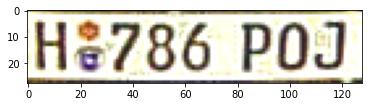

In [47]:
Engine_Evaluation(Engine='T', lang='plate_model_2')

picture: 1
Plate:  56TKJL Found plates:  ['A', 'N', 'W']
Max accuracy: 0.0
Speed: 5.883

Plate:  56TKJL Found plates:  ['565TKJL', '56TR3L', '5HTR3L', '56TRJL']
Max accuracy: 0.9230769230769231
Speed: 4.766


picture: 2
Plate:  PJ034T Found plates:  ['NPWBBRBTRRW4LLL', 'ELBBRERTSRS1LTL', 'REEIIILYSZL8IEEECTVLTLALL', 'C3NBRBRERRL', 'NBIRTHBB03BR3BEIELTTSGLL', 'RECSLLE3EZLAEEXLILWLTBRLZT', 'BENI3BRBBERE5ETEAE', 'NFEBBBRB3RC4LCL', 'BLILETZEWIVLTLZ3LZ', 'NCNRB23RRRL04LZL']
Max accuracy: 0.2
Speed: 6.077


picture: 3
Plate:  07NJB5 Found plates:  ['U7XIR5', '07XJB5', '07KJB5', '07XIB5', '07X1BS', '07X12T', '07NIB5', '07XIRS']
Max accuracy: 0.8333333333333334
Speed: 5.156


picture: 4
Plate:  17HKLG Found plates:  ['TTZ', 'I7RSZ3', 'TTCZZ', 'FZLLT', 'J72ZLSLZ', 'IFEULZ', 'FFTLLT', 'TTZZT', 'FF1LT1', 'TTCLT']
Max accuracy: 0.3333333333333333
Speed: 5.175


picture: 5
Plate:  J179RT Found plates:  ['09', 'T03', '0P2', '1P91', '03', '91', '022', '02', 'C21']
Max accuracy: 0.4
Speed: 4.635

Plat

Plate:  BX41PZ Found plates:  ['BX41PZ']
Max accuracy: 1.0
Speed: 17.26


picture: 36
Plate:  GX02BCF Found plates:  ['GX02BCF', 'UX02BLF', 'GXU2BLF', 'GX0U2BCF', 'GXU2BCF']
Max accuracy: 1.0
Speed: 5.298


picture: 37
Plate:  H786POJ Found plates:  ['H8788P0J', 'H5786P0J', 'H8786P0J']
Max accuracy: 0.8
Speed: 5.171


Average time: 6.11
Average accuracy: 0.5149527860054176


(6.11, 0.5149527860054176)

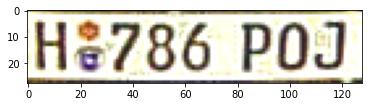

In [48]:
Engine_Evaluation(Engine='T', lang='plate_model_3')

picture: 1
Plate:  56TKJL Found plates:  ['8', 'W', 'A', 'V', '1']
Max accuracy: 0.0
Speed: 5.87

Plate:  56TKJL Found plates:  ['56TR3L', '56TE3L', '56TK3L', '55TK3L', 'L6TK3L']
Max accuracy: 0.8333333333333334
Speed: 4.805


picture: 2
Plate:  PJ034T Found plates:  ['BZB2EBESTX2XLCZZ', 'BTBEBET8RLCLTC', 'BZT22BZTZ2ZLZ', 'BERBBBC3BBZTBB2ZTZZECL', 'BZTBB2BETEBXCZC', 'BE5ABEEB2ETEZELL8XZ', 'BEETBBB0EBE2B3ETBZCL', 'ES5TSEEZ2Z2ZEEEETLZB6ZZ', 'E5RBET3EESEECZCAZZ', 'BZTBB2ZEZT22CZC']
Max accuracy: 0.23076923076923078
Speed: 5.903


picture: 3
Plate:  07NJB5 Found plates:  ['07XJB5', '07XJB5', '07KJB5', '07XB5', '07XJBS', 'C7XIB5']
Max accuracy: 0.8333333333333334
Speed: 5.151


picture: 4
Plate:  17HKLG Found plates:  ['TTCZZ', 'T71LZ', 'T2ELZ', 'F7ZCLZ', 'I7ZX1LZ', 'TTCZ', 'I72Z8Z', 'TZZZ', 'KCC2E', 'F7Z1LZ']
Max accuracy: 0.36363636363636365
Speed: 5.717


picture: 5
Plate:  J179RT Found plates:  ['428T', '72Z22', '422T', '72Z21', '428', '42Z2T', '42Z8T', '42Z21']
Max accuracy: 0.2
Speed:

Plate:  H786POJ Found plates:  ['H2786P0J', 'H8786PDJ', 'H8786P0J', 'HZ2786P0J']
Max accuracy: 0.8
Speed: 5.136


Average time: 6.11595744680851
Average accuracy: 0.5009532039280323


(6.11595744680851, 0.5009532039280323)

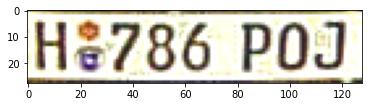

In [49]:
Engine_Evaluation(Engine='T', lang='plate_model_4')

picture: 1
Plate:  56TKJL Found plates:  ['', 'X', 'I']
Max accuracy: 0.0
Speed: 6.731

Plate:  56TKJL Found plates:  ['J6TJL', 'J6TJL', '5BTJL', 'TJL', '6TKJL', '6TEZ4L', 'ATJL', '5BTKJL', '56TRJL', '6TJL']
Max accuracy: 0.9090909090909091
Speed: 5.538


picture: 2
Plate:  PJ034T Found plates:  ['ETFIFZLALZLA', 'EDEEEZBIL', 'FEZLCIIX', 'FFCIZI', 'EFI8LEIHFCLLI', 'FIEFZII', 'TSAITX9', 'FIZ7LZ8EELFLA', 'EFEEILBEL', 'IIZIL29']
Max accuracy: 0.15384615384615385
Speed: 6.687


picture: 3
Plate:  07NJB5 Found plates:  ['07I1BG', '07IBG', '07K1B5', '073L1B', 'D07I3B5', 'G7I0BG', '871BE', 'D7IZJB5', 'G7I1BG']
Max accuracy: 0.6666666666666666
Speed: 6.075


picture: 4
Plate:  17HKLG Found plates:  ['FG', 'TIES', 'IE', 'IEZI', 'F4GEE', 'IFT', 'TFE', 'T', 'IEI', 'IET']
Max accuracy: 0.25
Speed: 5.713


picture: 5
Plate:  J179RT Found plates:  ['Z', 'ZP', '42P', '47A', '44', '4', '4Z2', '42', '2']
Max accuracy: 0.2222222222222222
Speed: 5.198

Plate:  J179RT Found plates:  ['II44A5', 'II444A', 'I

Plate:  H786POJ Found plates:  ['HB8B6GPLJJ', 'H88GPJJ', 'H86PJ', 'H88GPTJ', 'HE8GPTJI', 'HEGPJJ', 'HB8GJJ', 'HG8GJ', 'H886PTJ']
Max accuracy: 0.8333333333333334
Speed: 5.368


Average time: 7.087617021276595
Average accuracy: 0.43344306765359397


(7.087617021276595, 0.43344306765359397)

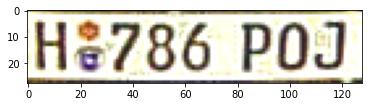

In [50]:
Engine_Evaluation(Engine='T', lang='plate_model_5')

picture: 1
Plate:  56TKJL Found plates:  ['A', '', 'T']
Max accuracy: 0.2857142857142857
Speed: 7.285

Plate:  56TKJL Found plates:  ['BTK3L', 'BTK3L', '6TK3L', '6TK3L', 'BTF3L', 'E6TE3L', 'T3L', '6TK3L', '56TF3L', '5TY3L']
Max accuracy: 0.7272727272727273
Speed: 5.493


picture: 2
Plate:  PJ034T Found plates:  ['L2XILCZ5', 'ILIRZELZZZLL', 'LLTLZXL', 'ELZ35LZ34', 'LZY3Z85L4Z', 'LZZLTTZLVLZLZT', 'LTZ4ZLZXL', 'EY2ZE2XZ', 'LLLT2ZL', 'LZZLZEEZVZXZ']
Max accuracy: 0.26666666666666666
Speed: 7.14


picture: 3
Plate:  07NJB5 Found plates:  ['O7512', 'O7XTB5', '07NJB5', 'D7KJB5', 'Z735125', 'C7351E', '07N7B5', 'D731']
Max accuracy: 1.0
Speed: 5.715


picture: 4
Plate:  17HKLG Found plates:  ['ZQEI', 'FFLTZT', 'TEE', 'TFZITTI', 'T5EEZ', 'FFEZS', 'TIEZ', 'ZE1CTI', 'F4CFZ', 'TEZ']
Max accuracy: 0.16666666666666666
Speed: 6.037


picture: 5
Plate:  J179RT Found plates:  ['Z2', '4ZQ2', '4ZCS', 'ZZS', 'ZZ', 'ZLS', '4ZLS', '4ZL']
Max accuracy: 0.0
Speed: 6.05

Plate:  J179RT Found plates:  ['LLLDT', 

Plate:  GX02BCF Found plates:  ['GXUZ2BC', 'GXO2BCF', 'GXO2BCIF', 'GXUO2BCIF', 'GXU2BCF', 'UXU2BCF', 'GXO2BCF']
Max accuracy: 0.8571428571428571
Speed: 5.429


picture: 37
Plate:  H786POJ Found plates:  ['HE786DDJ', 'HE786D0J', 'H5786DDJ', 'HG786D0J', 'H78G6DLLI', 'HG786I20', 'HS786DJ', 'H786DDJJ', 'H5786DDI', 'HS786DJJ']
Max accuracy: 0.7142857142857143
Speed: 5.32


Average time: 7.15051063829787
Average accuracy: 0.4770415744099955


(7.15051063829787, 0.4770415744099955)

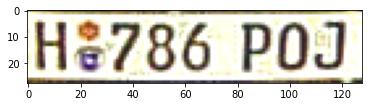

In [51]:
Engine_Evaluation(Engine='T', lang='plate_model_6')

picture: 1
Plate:  56TKJL Found plates:  ['3', 'X', 'I', 'Z']
Max accuracy: 0.0
Speed: 5.877

Plate:  56TKJL Found plates:  ['J4JLJL', 'J6TTZZ1L', '3JZ', 'JJC3L', 'JGTJLZL', 'G6TYJL', 'JGTJZZ', 'JGTCZZ', 'ZSZ', '5FKCZ']
Max accuracy: 0.6666666666666666
Speed: 5.263


picture: 2
Plate:  PJ034T Found plates:  ['LZZZZZ4SSTZXFZZAL', 'EZZSZ4ESTSFZZZXLX', 'LZZYZZZREZZAXTXBELBZZLZ', 'ZZLZFXZLTTTZZLZK4ZZXL2', 'LZETZZZZZ', 'LZZZEEZCZCZZZ', 'LZZZ4ZZZZ', 'ZT4ZXZZZ4E2XFCZLLL', 'L7ZXZFXZZFSXICZZZ', 'ZLZFXZ7XFZZXXZZ']
Max accuracy: 0.17391304347826086
Speed: 5.949


picture: 3
Plate:  07NJB5 Found plates:  ['Q7XZTZ5', 'G7171Z', 'Q7XZ1Z55', 'Q7XZ1B5', '07BZ3B5', 'G7SZ1E2G', 'Z7TS1Z5', '77171ZS', '07BZ3BJ5', '07Z7B5']
Max accuracy: 0.6666666666666666
Speed: 5.163


picture: 4
Plate:  17HKLG Found plates:  ['ZTZ', 'JEZ4Z', 'TZZZZ', 'ZZCZZZ', 'FZZTZ', '7ZFZZ', '7ZFJZ', 'F4Z', 'FFZ', 'IFEZZ']
Max accuracy: 0.18181818181818182
Speed: 5.176


picture: 5
Plate:  J179RT Found plates:  ['7ZD2', '47ZD2', '47ZD

Plate:  47JRLV Found plates:  ['47JRLV', '477JRL', '4JLWV', '47JLV']
Max accuracy: 1.0
Speed: 5.742

Plate:  47JRLV Found plates:  ['92JJP12', '92MJD1J', '92JJP13', '92NL', '92JJ1', '22JJ1J', '92MJ7LX', '92NLX', '92TPLX']
Max accuracy: 0.3076923076923077
Speed: 4.438

Plate:  47JRLV Found plates:  ['Z3', '33', 'ZJ', 'X', 'ZJ', 'ZX']
Max accuracy: 0.25
Speed: 4.243

Plate:  47JRLV Found plates:  ['Z77JJ', 'Z74JJJJ', 'ZJ7JJ', 'Z747JJ', 'Z34JJ', 'Z74JJJ']
Max accuracy: 0.5
Speed: 5.279


picture: 33
Plate:  31PXKR Found plates:  ['JPJJ', 'JPJX', 'JPJXJ', '1PJX', '1PJJ', '1PJ']
Max accuracy: 0.6
Speed: 5.522


picture: 34
Plate:  KN621V Found plates:  ['IZH6211J', 'IX1JZ21X1F', 'IX1JZ62141F', 'IH4G21V1J', 'IZH752141F', 'IC1752141F', 'IJLZ21Y', 'IZ1IZ62J51J', 'IZH7G21S1J', 'IZI7421V1J']
Max accuracy: 0.42857142857142855
Speed: 4.741


picture: 35
Plate:  BX41PZ Found plates:  ['BJ412Z', 'BJ412Z', 'BY412Z']
Max accuracy: 0.6666666666666666
Speed: 17.728


picture: 36
Plate:  GX02BCF Found pl

(7.087510638297871, 0.4171488102939173)

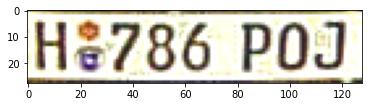

In [52]:
Engine_Evaluation(Engine='T', lang='plate_model_7')

# Conclusie
Tesseract scoort dus het hoogst (afgezien van Google) en hiermee zal dus verder gewerkt worden. plate_model_4 en plate_model_3 scoren beiden als custom model het hoogst. Er zal verder gewerkt worden met plate_model_4 omdat deze met meer data getraind is en wellicht robuuster kan zijn op de lange termijn. plate_model_3 wordt wel als extra bijgeleverd indien er interesse is in verder onderzoek. 

# Bronnen
Brownlee, J. (2020, September 1). How to Train an Object Detection Model with Keras. Machine Learning Mastery. https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/

Matterport, M. (2018, March 20). matterport/Mask_RCNN. GitHub. https://github.com/matterport/Mask_RCNN

Theophilebuyssens, T. (2020, January 28). License Plate Recognition using OpenCV, YOLO and Keras. Medium. https://medium.com/@theophilebuyssens/license-plate-recognition-using-opencv-yolo-and-keras-f5bfe03afc65